# Competição ML @SBS/DAA - 5ª Edição (2022/2023)

Esta competição está relacionada com o Trabalho Prático de Grupo das UCs do perfil Machine Learning: Fundamentos e Aplicações da Uminho e da UC Dados e Aprendizagem Automática, tendo, como destinatários, alunos do Mestrado em Engenharia Informática, do Mestrado em Matemática e Computação, e do Mestrado em Engenharia de Sistemas.

# Descrição da Competição
A previsão da quantidade de incidentes rodoviários é um conhecido problema de características estocásticas, não-lineares. Tem, contudo, aparecido na literatura um conjunto de modelos que demonstram um potencial assinalável neste tipo de previsões. Com isso em consideração, foi construído um dataset que contém dados referentes à quantidade e características dos incidentes rodoviários que ocorreram na cidade de Guimarães em 2021 (o dataset cobre um período que vai desde o dia 01 de Janeiro de 2021 até ao dia 31 de Dezembro do mesmo ano).

Com esta competição espera-se que os alunos desenvolvam e otimizem modelos de Machine Learning que sejam capazes de prever o número de incidentes rodoviários que irão acontecer na cidade de Guimarães a uma determinada hora.

## Imports utilizados

In [190]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# matplotlib inline

# Instalar as dependências necessárias

In [191]:
!pip install holidays

### Mudar o modo que a Interactive shell imprime as variáveis

In [192]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Carregar os dataset de treino e de teste

In [193]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

In [194]:
train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

#### Seed utilizada

In [195]:
SEED = 101

## Preparação de Dados

In [196]:
# Não tratar outliers de 'affected_roads', 'hour', 'day', 'month', 'weekday', 'weekend', 'holiday'
numeric_columns = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'luminosity']

### Converter features categóricas para valores numéricos

In [197]:
categorical_to_numerical = {
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2
    },
    'magnitude_of_delay': {
        'UNDEFINED': 0,
        'MODERATE': 1,
        'MAJOR': 2
    }
}

In [198]:
from pandas import DataFrame
import holidays

dropped_columns = ['city_name','avg_precipitation', 'magnitude_of_delay']

# noinspection PyPep8Naming
def decision_tree_data_preparation(df: DataFrame) -> DataFrame:
    prep_df = df.drop(dropped_columns, axis=1)

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Agrupar em 2 bins a feature 'avg_rain'
    prep_df.loc[prep_df['avg_rain'] == 'Sem Chuva', 'rain_level'] = 0
    prep_df.loc[prep_df['avg_rain'] != 'Sem Chuva', 'rain_level'] = 1

    prep_df.drop(columns=['avg_rain'], inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['hour'] = record_date.hour
    prep_df['day'] = record_date.day
    prep_df['month'] = record_date.month
    prep_df['weekday'] = record_date.weekday
    
    ### Verificar se a data se refere a um dia de fim-de-semana ou não.
    weekend = []
    for weekday in prep_df['weekday']:
        if weekday == 5 or weekday == 6:
            weekend.append(1)
        else:
            weekend.append(0)
    prep_df['weekend'] = weekend

    ### Criar 5 bins para a feature 'hour' consoante as horas do dia e a sua quantidade de tráfego.
    def hour_of_the_day(hour):
        if hour == 24 or 0 < hour < 8:
            return 1
        elif 8 <= hour < 12:
            return 2
        elif 12 <= hour < 16:
            return 3
        elif 16 <= hour < 20:
            return 4
        else:
            return 5

    prep_df["hour"] = prep_df["hour"].apply(hour_of_the_day)

    ### Verificar se a data se refere a um feriado português.
    portugueseHolidays = holidays.Portugal()

    def is_it_holiday(date_time):
        if date_time in portugueseHolidays:
            return 1
        else:
            return 0

    prep_df["holiday"] = prep_df["record_date"].apply(is_it_holiday)
    
    prep_df.drop(columns=['record_date'], inplace=True)

    ### Quantificar a feature 'affected_roads' para o número único de estradas afetadas
    road_quantity = []
    for line in prep_df['affected_roads']:
        unique_roads = set(str(line).split(','))
        valid_roads = [elem for elem in unique_roads if elem != '']
        count = len(valid_roads)
        road_quantity.append(count)

    prep_df['affected_roads'] = road_quantity

    ### Ao analisar o resultado pós-tratamento, verificámos que a feature 'affected_roads' tinha alta correlação com 'delay_in_minutes'
    prep_df.drop(columns=['affected_roads'], inplace=True)

    ### Converter a feature 'delay_in_seconds' para 'delay_in_minutes' de modo a reduzir o intervalo de valores
    delay_in_minutes = []
    for seconds in prep_df['delay_in_seconds']:
        minutes = seconds / 60
        delay_in_minutes.append(minutes)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes
    
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))
    
    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    i = 0
    for num in numeric_columns:
        median = np.median(prep_df[num])
        prep_df.loc[prep_df[num] <= whiskers[i][1], num] = median
        prep_df.loc[prep_df[num] >= whiskers[i][2], num] = median
        i = i + 1
        
    return prep_df

### Divisão do dataset de treino em dados de treino e de teste

In [199]:
from sklearn.model_selection import train_test_split

X = decision_tree_data_preparation(train_df)

y = X['incidents']

X.drop(columns=['incidents'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Modelo de Árvore de decisão

In [200]:
clf = DecisionTreeClassifier(random_state=SEED)

clf.fit(X_train, y_train)

scoresDT = cross_val_score(clf, X, y, cv=200)

"""
# Validação cruzada (K Fold)
from sklearn.svm import SVC

cross_valid_model = SVC(random_state=2021)
scoresSVC = cross_val_score(cross_valid_model, X, np.ravel(y), cv=2)

scoresSVC
"""
print("Accuracy de %0.2f com um desvio padrão de %0.2f" % (scoresDT.mean(), scoresDT.std()))

DecisionTreeClassifier(random_state=101)

'\n# Validação cruzada (K Fold)\nfrom sklearn.svm import SVC\n\ncross_valid_model = SVC(random_state=2021)\nscoresSVC = cross_val_score(cross_valid_model, X, np.ravel(y), cv=2)\n\nscoresSVC\n'

Accuracy de 0.91 com um desvio padrão de 0.05


#### Obter as previsões

In [201]:
predictions = clf.predict(X_test)

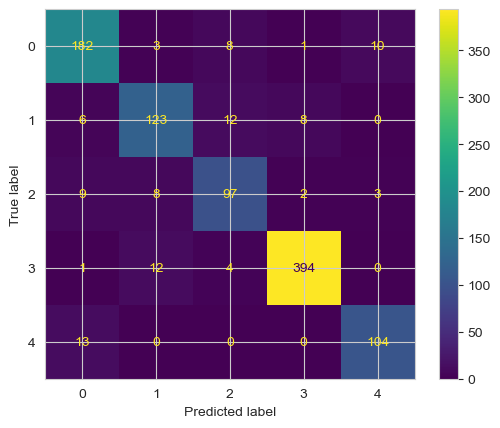

In [202]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [203]:
accuracy_score(y_test, predictions)
# (TP + TN) / (TP + FP + FN + TN)

precision_score(y_test, predictions, average='micro')
# TP / (TP + FP)

recall_score(y_test, predictions, average='micro')
# TP / (TP + FN)

0.9

0.9

0.9

# Reading the test dataset

In [204]:
X = decision_tree_data_preparation(test_df)

# Getting the predictions

In [205]:
predictions = clf.predict(X)

predictions_df = pd.DataFrame(predictions)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')